In [1]:
import shap
import pandas as pd
import xgboost as xgb
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
data = pd.read_csv("Dataset.csv")
data = data.drop(columns=['Year', 'Month'])
data.index = pd.date_range(start='2011-01', periods=159, freq='M')
data

,RentalNum(K),StationNum,BikeNum(K),LaneLength(km),FreePlan,Temperature,Humidity(%),Sunshine(hr),Rainfull(mm),Raindays,COVIDTaiwan(K),COVIDTaipei(K),MRTCarryNum(K),BusCarryNum(K)
2011-01-31,9.4,21,3.0,236.71,1,13.7,83,17.1,71.9,25,0.0,0.0,46769.3,52353.0
2011-02-28,18.6,21,3.0,236.71,1,16.9,78,87.8,68.0,14,0.0,0.0,42217.6,42942.6
2011-03-31,6.3,21,3.0,236.71,1,16.2,74,55.0,119.1,12,0.0,0.0,48818.4,55112.5
2011-04-30,35.8,21,3.0,236.71,1,21.7,68,153.1,27.4,7,0.0,0.0,47205.2,51527.5
2011-05-31,28.1,21,3.0,236.71,1,24.8,78,94.2,222.0,18,0.0,0.0,46653.3,54115.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,4463.0,1332,17.9,516.38,0,22.4,73,155.9,17.0,8,1.0,0.1,62840.8,34722.7
2023-12-31,4062.5,1337,18.9,516.38,0,18.8,81,87.4,89.0,8,1.3,0.2,67308.2,35235.1
2024-01-31,4026.4,1341,18.9,516.38,0,16.9,76,107.1,37.5,10,2.5,0.3,62741.7,34108.2
2024-02-29,3689.4,1348,20.9,518.27,0,18.0,80,110.7,43.0,5,2.4,0.2,54529.7,28616.4


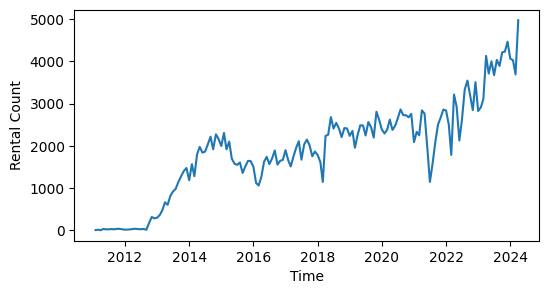

In [3]:
plt.figure(figsize=(6, 3))
plt.plot(data.index, data['RentalNum(K)'])
plt.xlabel('Time')
plt.ylabel('Rental Count')
plt.show()

In [4]:
X = sm.add_constant(data.drop(columns=['RentalNum(K)']))
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

           Feature          VIF
0            const  1302.045626
1       StationNum     6.718117
2       BikeNum(K)    10.394523
3   LaneLength(km)    10.238823
4         FreePlan     5.548848
5      Temperature     3.847805
6      Humidity(%)     2.434083
7     Sunshine(hr)     4.009742
8     Rainfull(mm)     2.341251
9         Raindays     2.200902
10  COVIDTaiwan(K)    17.497163
11  COVIDTaipei(K)    17.105958
12  MRTCarryNum(K)     8.670821
13  BusCarryNum(K)    22.003685


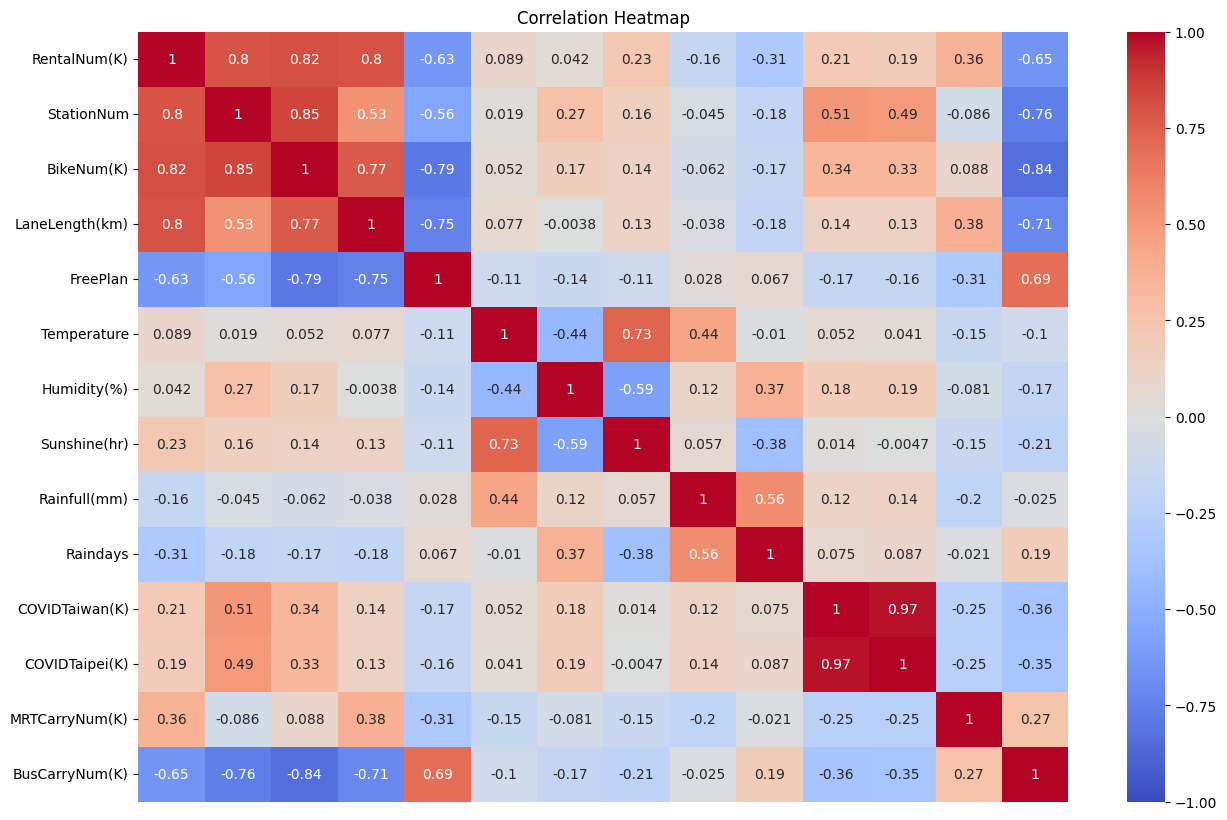

In [5]:
correlation_matrix = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, xticklabels=False)
plt.title("Correlation Heatmap")
plt.show()

In [6]:
X = sm.add_constant(data.drop(columns=['RentalNum(K)', 'COVIDTaipei(K)', 'BikeNum(K)']))
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

           Feature          VIF
0            const  1193.683091
1       StationNum     3.914979
2   LaneLength(km)    10.036509
3         FreePlan     4.941856
4      Temperature     3.825419
5      Humidity(%)     2.362147
6     Sunshine(hr)     3.914714
7     Rainfull(mm)     2.301903
8         Raindays     2.185400
9   COVIDTaiwan(K)     1.554458
10  MRTCarryNum(K)     8.642229
11  BusCarryNum(K)    21.345608


In [7]:
data = data.drop(columns=['COVIDTaipei(K)', 'BikeNum(K)'])
training_data = data.sample(frac=0.8, random_state=20240608).sort_index()
test_data = data.drop(training_data.index).sort_index()
x_train = training_data.drop(columns=['RentalNum(K)'])
y_train = training_data['RentalNum(K)']
x_test = test_data.drop(columns=['RentalNum(K)'])
y_test = test_data['RentalNum(K)']

### Linear Regression

In [8]:
def stepwise_selection(X, y, initial_list=[], verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        best_aic = float('inf')
        best_feature = None
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            aic = model.aic
            if aic < best_aic:
                best_aic = aic
                best_feature = new_column
        if best_aic < (sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()).aic:
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:15} with AIC {:.6}'.format(best_feature, best_aic))

        # Backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        worst_aic = model.aic
        worst_feature = None
        for feature in included:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[[col for col in included if col != feature]]))).fit()
            aic = model.aic
            if aic < worst_aic:
                worst_aic = aic
                worst_feature = feature
        if worst_feature is not None:
            included.remove(worst_feature)
            changed = True
            if verbose:
                print('Drop {:15} with AIC {:.6}'.format(worst_feature, worst_aic))

        if not changed:
            break
    return included

In [9]:
print("Stepwise Summary:")
print("-------------------------------------")
selected_features = stepwise_selection(x_train, y_train)

Stepwise Summary:
-------------------------------------
Add  LaneLength(km)  with AIC 2011.01
Add  StationNum      with AIC 1918.62
Add  MRTCarryNum(K)  with AIC 1871.45
Add  Raindays        with AIC 1852.43
Add  FreePlan        with AIC 1841.01
Add  COVIDTaiwan(K)  with AIC 1827.35
Add  Temperature     with AIC 1812.14
Add  BusCarryNum(K)  with AIC 1804.47
Add  Rainfull(mm)    with AIC 1801.01
Drop Raindays        with AIC 1799.89


In [10]:
print("Selected features:", selected_features)

Selected features: ['LaneLength(km)', 'StationNum', 'MRTCarryNum(K)', 'FreePlan', 'COVIDTaiwan(K)', 'Temperature', 'BusCarryNum(K)', 'Rainfull(mm)']


In [11]:
x_train_selected = sm.add_constant(x_train[selected_features])
final_model = sm.OLS(y_train, x_train_selected).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:           RentalNum(K)   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     230.2
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           3.21e-68
Time:                        20:37:30   Log-Likelihood:                -890.94
No. Observations:                 127   AIC:                             1800.
Df Residuals:                     118   BIC:                             1825.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2590.1882    463.690     -5.

In [12]:
x_test_selected = sm.add_constant(x_test[selected_features])
y_pred = final_model.predict(x_test_selected)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** (1/2)
print("Root Mean Squared Error on test data:", round(rmse, 2))

Root Mean Squared Error on test data: 222.25


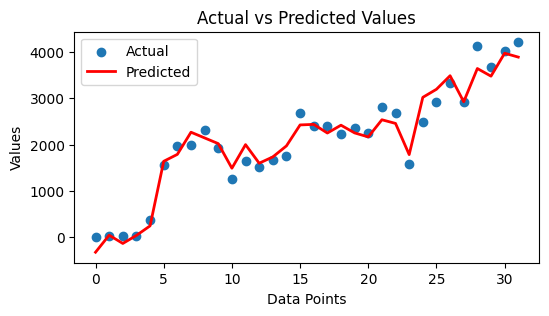

In [13]:
plt.figure(figsize=(6, 3))
plt.scatter(range(len(y_pred)), y_test, label='Actual')
plt.plot(range(len(y_pred)), y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

### XGBoost

In [14]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
params = {
    'objective': 'reg:squarederror',
    'max_depth': 3,
    'eta': 0.05,
    'seed': 20240608
}
num_rounds = 1000
bst = xgb.train(params, dtrain, num_rounds)

In [15]:
y_pred = bst.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** (1/2)
print("Root Mean Squared Error on test data:", round(rmse, 2))

Root Mean Squared Error on test data: 180.03


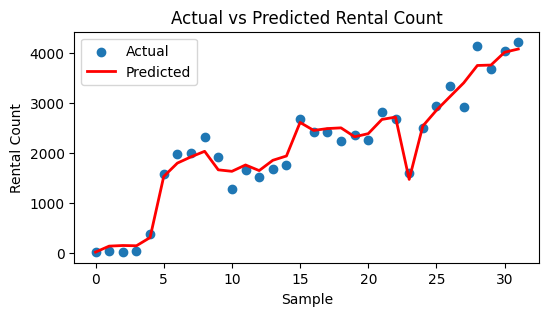

In [16]:
plt.figure(figsize=(6, 3))
plt.scatter(range(len(y_pred)), y_test, label='Actual')
plt.plot(range(len(y_pred)), y_pred, color='red', linewidth=2, label='Predicted')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Rental Count')
plt.title('Actual vs Predicted Rental Count')
plt.show()

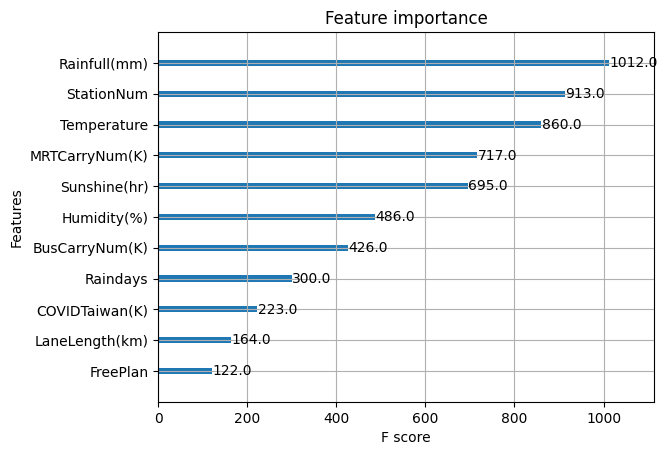

In [17]:
xgb.plot_importance(bst)
plt.show()